In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:5]:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/license-plate-detection-yolov8n/pytorch/default/1/runs/detect/train/weights/best.pt
/kaggle/input/large-license-plate-dataset/labels/val.cache
/kaggle/input/large-license-plate-dataset/labels/train.cache
/kaggle/input/large-license-plate-dataset/labels/val/790e3002a96d85a5.txt
/kaggle/input/large-license-plate-dataset/labels/val/688f112cf2794184.txt
/kaggle/input/large-license-plate-dataset/labels/val/ab2cff14a7b52e36.txt
/kaggle/input/large-license-plate-dataset/labels/val/6687bdff027c5b55.txt
/kaggle/input/large-license-plate-dataset/labels/val/0dee0d9dfd8e3cfa.txt
/kaggle/input/large-license-plate-dataset/labels/test/c1d8b110186e095a.txt
/kaggle/input/large-license-plate-dataset/labels/test/28e26a4eb646c67a.txt
/kaggle/input/large-license-plate-dataset/labels/test/b1a50a3824887ee2.txt
/kaggle/input/large-license-plate-dataset/labels/test/19eba8ac64eed194.txt
/kaggle/input/large-license-plate-dataset/labels/test/18098dc9ee6aad80.txt
/kaggle/input/large-license-plate-dat

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.6 MB/s eta 0:00:00a 0:00:01


In [3]:
import os
import cv2
import yaml
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
print(torch.cuda.is_available())

from ultralytics import YOLO

False
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
def list_directory_tree_with_os_walk(starting_directory):
    for root, directories, files in os.walk(starting_directory):
        print(f"Directory: {root}")
list_directory_tree_with_os_walk('/kaggle/input/large-license-plate-dataset')

Directory: /kaggle/input/large-license-plate-dataset
Directory: /kaggle/input/large-license-plate-dataset/labels
Directory: /kaggle/input/large-license-plate-dataset/labels/val
Directory: /kaggle/input/large-license-plate-dataset/labels/test
Directory: /kaggle/input/large-license-plate-dataset/labels/train
Directory: /kaggle/input/large-license-plate-dataset/images
Directory: /kaggle/input/large-license-plate-dataset/images/val
Directory: /kaggle/input/large-license-plate-dataset/images/test
Directory: /kaggle/input/large-license-plate-dataset/images/train


In [5]:
shutil.copytree('/kaggle/input/large-license-plate-dataset/images/train/', '/kaggle/working/dataset/train/images')
shutil.copytree('/kaggle/input/large-license-plate-dataset/labels/train/', '/kaggle/working/dataset/train/labels')
shutil.copytree('/kaggle/input/large-license-plate-dataset/images/val/', '/kaggle/working/dataset/validation/images')
shutil.copytree('/kaggle/input/large-license-plate-dataset/labels/val/', '/kaggle/working/dataset/validation/labels')
shutil.copytree('/kaggle/input/large-license-plate-dataset/images/test/', '/kaggle/working/dataset/test/images')
shutil.copytree('/kaggle/input/large-license-plate-dataset/labels/test/', '/kaggle/working/dataset/test/labels')

'/kaggle/working/dataset/test/labels'

In [9]:
# !rm -rf /kaggle/working/*

In [6]:
list_directory_tree_with_os_walk('/kaggle/working/dataset')

Directory: /kaggle/working/dataset
Directory: /kaggle/working/dataset/train
Directory: /kaggle/working/dataset/train/images
Directory: /kaggle/working/dataset/train/labels
Directory: /kaggle/working/dataset/test
Directory: /kaggle/working/dataset/test/images
Directory: /kaggle/working/dataset/test/labels
Directory: /kaggle/working/dataset/validation
Directory: /kaggle/working/dataset/validation/images
Directory: /kaggle/working/dataset/validation/labels


In [7]:
training_conf={'path':'/kaggle/working/dataset','train':'train/images','test':'test/images','val':'validation/images','names':{0:'license_plate'}}
with open('data.yaml','w') as yaml_file:
    yaml.dump(training_conf,yaml_file,sort_keys=False)

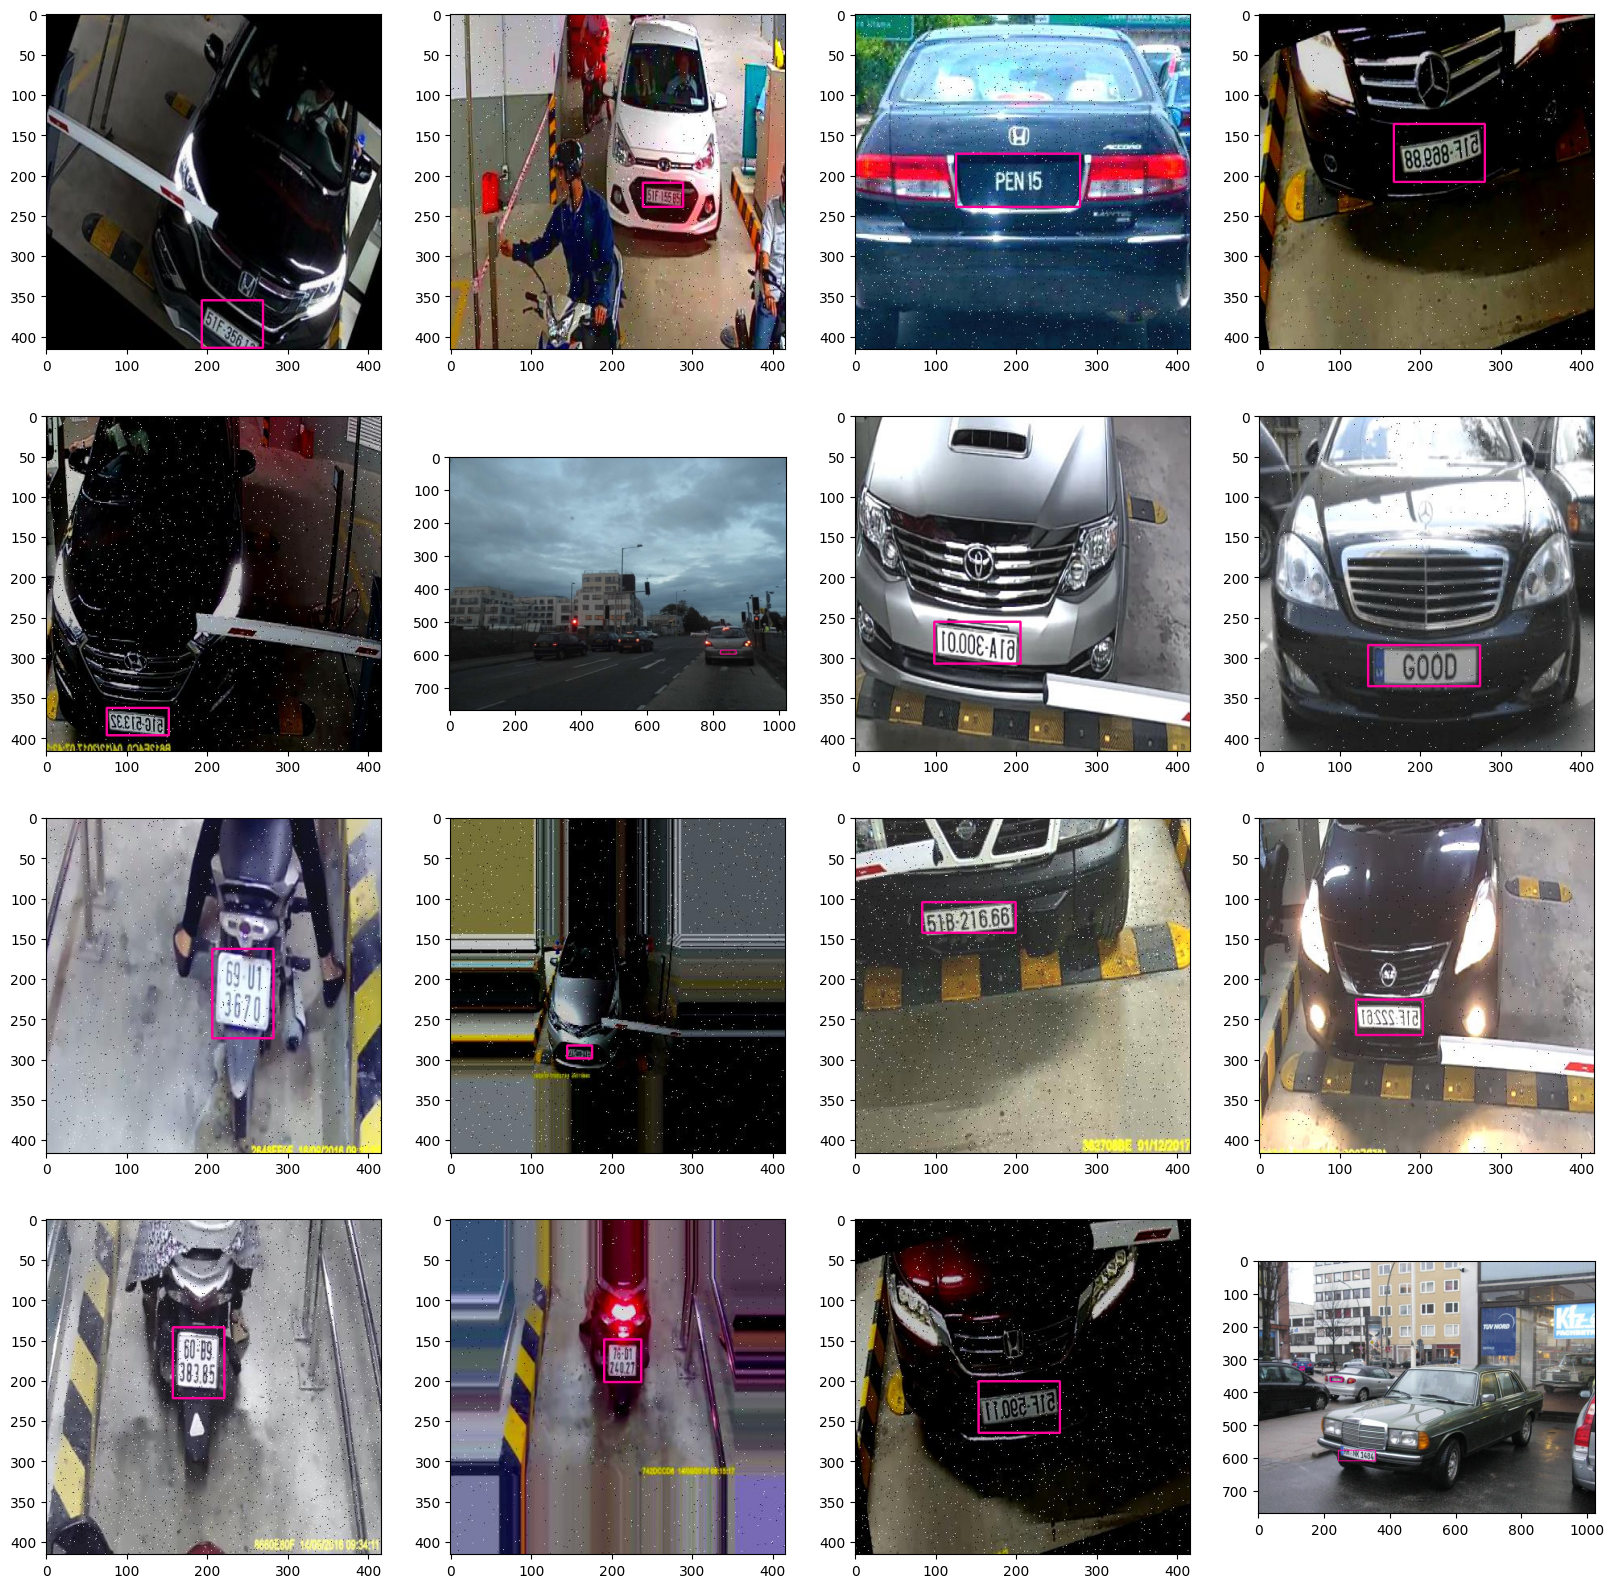

In [8]:
IMG_DATA = "/kaggle/working/dataset/{}/images"
LABELA_DATA = "/kaggle/working/dataset/{}/labels"

def preprocess_bbox(bbox_data, img_height, img_width):
    
    bbox_data = bbox_data.strip('\n')
    # class, bbox center x, bbox center y, h, w
    _, x, y, w, h = map(float, bbox_data.split(" "))
    x1 = int((x - w / 2) * img_width)
    x2 = int((x + w / 2) * img_width)
    y1 = int((y - h / 2) * img_height)
    y2 = int((y + h / 2) * img_height)
    
    return [x1, y1, x2, y2]   


def plot_labeled_data(mode='train'):

    fig = plt.figure(figsize=(20, 20)) 
    rows = 4
    columns = 4
    
    imgs_list = os.listdir(IMG_DATA.format(mode))
    labels_list = os.listdir(LABELA_DATA.format(mode))
    
    for i, img_name in enumerate(imgs_list[:16]):
        
        img = cv2.imread(os.path.join(IMG_DATA.format(mode), img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_h, img_w, _ = img.shape
        
        fl = open(os.path.join(LABELA_DATA.format(mode), img_name[:-3] + 'txt'), 'r')
        data = fl.readlines()
        for d in data:
            bbox = preprocess_bbox(d, img_h, img_w)
            cv2.rectangle(img=img, pt1=(bbox[0], bbox[1]), pt2=(bbox[2], bbox[3]), color=(255, 0, 155), thickness=2)
        fl.close()
        fig.add_subplot(rows, columns, i+1) 
        plt.imshow(img)
    plt.show()
    
plot_labeled_data()

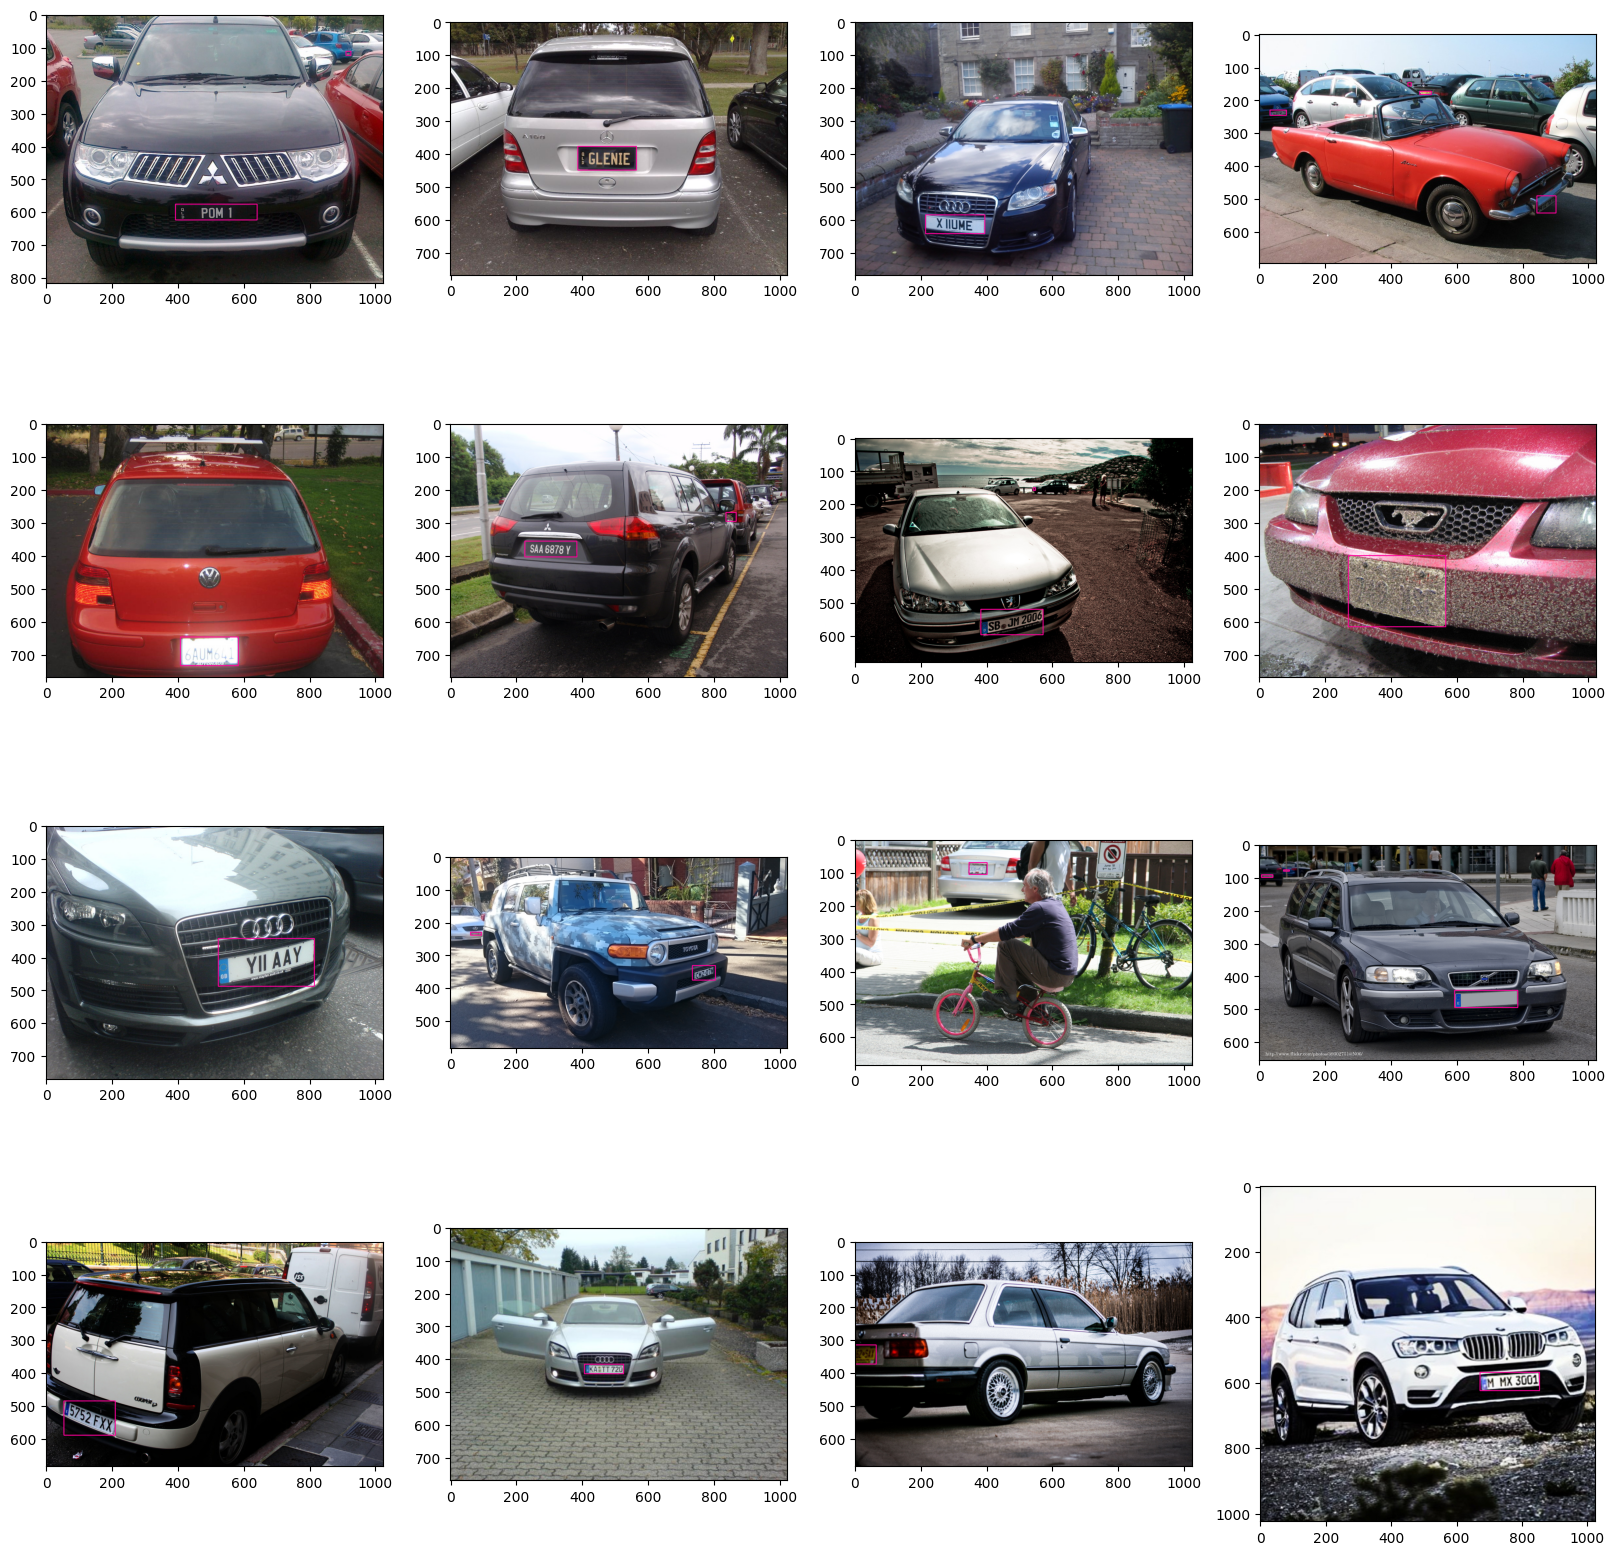

In [9]:
plot_labeled_data('test')

In [10]:
pretrained="/kaggle/input/license-plate-detection-yolov8n/pytorch/default/1/runs/detect/train/weights/best.pt"

In [11]:
 # model=YOLO('yolov8n.pt')
 model=YOLO(pretrained)

In [19]:
# results=model.train(data='data.yaml',epochs=50,imgsz=640,patience=10)

TypeError: 'str' object is not callable

In [21]:
metrics=model.val(data='data.yaml',split='test',conf=0.15,iou=0.3)

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2810.6±488.9 MB/s, size: 254.0 KB)
val: Scanning /kaggle/working/dataset/test/labels... 386 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 386/386 1.4Kit/s 0.3s<0.2s
val: New cache created: /kaggle/working/dataset/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 6.2it/s 4.0s0.1ss
                   all        386        512      0.881      0.726      0.836      0.582
Speed: 1.0ms preprocess, 3.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /kaggle/working/runs/detect/val


In [22]:
metrics.box.map,

(np.float64(0.5819328210275212),)

In [12]:
def predict_license_plate(imgs="/kaggle/working/dataset/test/images"):
    predictions=model.predict(source=imgs,conf=0.15,iou=0.3,classes=[0])
    return predictions
# predictions=predict_license_plate()

In [27]:
def preprocess_bbox(bbox,img_w,img_h):
    return [int(bbox[0]),int(bbox[1]),int(bbox[2]),int(bbox[3])]

def plot_labeled_data(predicted):
    fig=plt.figure(figsize=(20,20))
    rows=4
    cols=4
    for i,pred in enumerate(predicted):
        img_path=pred.path
        img=cv2.imread(img_path)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img_h,img_w,_=img.shape
        bboxes=pred.boxes.xyxy
        for bbox in bboxes:
            bbox=preprocess_bbox(bbox,img_w,img_h)
            cv2.rectangle(img=img,pt1=(bbox[0],bbox[1]),pt2=(bbox[2],bbox[3]),color=(255,0,155),thickness=2)
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
    plt.show()
plot_labeled_data(predictions[:16])

In [13]:
import pytesseract

In [14]:
pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

In [15]:
for root,_,files in os.walk("/usr/bin/tesseract"):
    print(root)

### Function to Detect License Plate Number:
We will define this function which will show the image and turn image into grayscale to simplify the processing and reduce computation. After that applies Gaussian blur to smooth the image and reduce noise making edge detection more accurate.

* #### cv2.imread(image_path):
Reads the image from the specified path.
* #### cv2.cvtColor(image, cv2.COLOR_BGR2GRAY):
Converts the image from color (BGR) to grayscale. Grayscale simplifies the image, making it easier to process further.
* #### cv2.GaussianBlur(gray, (5, 5), 0): 
Applies Gaussian Blur to the grayscale image. This reduces noise and smooths the image, making it easier for the edge detection step.

### Edge Detection using Canny and Contours in the Image
We will use Canny edge detection to highlight the edges in the image, making the plate contours clearer and then finds the contours of the objects in the image helping locate potential license plates.

* #### cv2.Canny(blurred, 100, 200):
  This is the Canny edge detection algorithm, which helps highlight the edges of the objects in the image. It is particularly useful for detecting the boundaries of the license plate.
* #### cv2.findContours:
Finds the contours (outlines) of objects in the image. Contours are the boundaries of objects that can be used to locate shapes like rectangles (license plates).
* #### cv2.RETR_EXTERNAL: 
This flag ensures that only external contours are retrieved, excluding inner contours of objects.





### Approximate Contours and Check for a Rectangle
We will identify and approximates the contours that resemble the shape of a rectangular license plate.

* ### sorted(contours, key=cv2.contourArea, reverse=True):
Sorts the contours by their area, from largest to smallest. The largest contour is likely to be the license plate.
* ### cv2.approxPolyDP:
Approximates the contour to a polygon with fewer vertices.
* ### if len(approx) == 4: 
If the approximated contour has four vertices, it's likely a rectangle, which is the shape of most license plates.

### Extract License Plate and Apply Thresholding
We will extracts the license plate area and applies thresholding to convert it to a binary image for OCR processing.

* #### cv2.boundingRect:
Draws a rectangle around the detected license plate.
* #### cv2.threshold: 
Converts the license plate region into a binary image (black and white), which is easier for OCR to process.

### OCR to Recognize Plate Number
We will use Tesseract OCR to recognize the text in the license plate image and return the plate number.

* #### pytesseract.image_to_string:
This function takes the preprocessed image (thresholded) and applies Tesseract OCR to extract the text (license plate number).
* #### --psm 8:
Configures Tesseract to treat the image as a single word, improving accuracy for plate number recognition.

In [19]:
def detect_plate_number(img_path):
    img=cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blurred=cv2.GaussianBlur(gray,(5,5),0)
    # Edge Detection using Canny and Contours in the Image
    edges=cv2.Canny(blurred,100,200)
    contours,_=cv2.findContours(edges.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    # Approximate Contours and Check for a Rectangle
    contours=sorted(contours,key=cv2.contourArea,reverse=True)
    plate_contour=None
    for contour in contours:
        eplison=0.02*cv2.arcLength(contour,True)
        approx=cv2.approxPolyDP(contour,eplison,True)
        if len(approx)==4:
            plate_contour=approx
            break
    # Extract License Plate and Apply Thresholding
    if plate_contour is not None:
        x,y,w,h=cv2.boundingRect(plate_contour)
        plate_image=gray[y:y+h,x:x+w]
        plt.imshow(plate_image)
        plt.show()
        _,thresh=cv2.threshold(plate_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        plate_number=pytesseract.image_to_string(thresh,config='--psm 8')
        return plate_number.strip()

In [65]:
import easyocr

### Calling the Function and Displaying the Output

In [74]:
def read_plate_number_from_predicted(img_path):
    predicted=predict_license_plate(img_path)
    for pred in predicted:
        if not pred.path:
            continue
        img=cv2.imread(pred.path)
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img_h,img_w,_=img.shape
        bboxes=pred.boxes.xyxy
        for bbox in bboxes:
            bbox=preprocess_bbox(bbox,img_w,img_h)
            x1,y1,x2,y2=bbox
            plate_image_o=img[y1:y2,x1:x2]
            plate_image = gray[y1:y2, x1:x2]
            plt.imshow(plate_image)
            plt.show()
            # 3.3
            # Resize
            plate_image = cv2.resize(
                plate_image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
            # Adaptive threshold
            thresh = cv2.adaptiveThreshold(plate_image, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, 11, 2)
            # Morphology
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
            thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
            # OCR
            config = "--oem 3 --psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-"
            # plate_number = pytesseract.image_to_string(thresh, config="--psm 8")
            # print("Plate number detected:", plate_number.strip())
            reader = easyocr.Reader(['en'])
            result = reader.readtext(plate_image, detail=1)
            # sort by x-coordinate of bounding box
            result = sorted(result, key=lambda x: x[0][0][0])
            plate_text = "".join([res[1] for res in result])
            print("Plate:", plate_text)




# 4.4
            # _,thresh=cv2.threshold(plate_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            # plate_number=pytesseract.image_to_string(thresh,config='--psm 8')
            # print("plate number detected: ",plate_number.strip())


# def read_plate_number_from_predicted(img_path):
#     predicted = predict_license_plate(img_path)

#     for pred in predicted:
#         img = cv2.imread(img_path)

#         plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#         plt.axis("off")
#         plt.show()

#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         img_h, img_w = gray.shape

#         bboxes = pred.boxes.xyxy.cpu().numpy()

#         for bbox in bboxes:
#             x1, y1, x2, y2 = preprocess_bbox(bbox, img_w, img_h)
#             plate_image = gray[y1:y2, x1:x2]

#             _, thresh = cv2.threshold(
#                 plate_image, 0, 255,
#                 cv2.THRESH_BINARY + cv2.THRESH_OTSU
#             )

#             plate_number = pytesseract.image_to_string(
#                 thresh, config='--psm 8'
#             )

#             print("Plate number detected:", plate_number.strip())



image 1/1 /kaggle/working/dataset/test/images/288a95c01e43cd14.jpg: 480x640 1 license_plate, 101.2ms
Speed: 3.1ms preprocess, 101.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


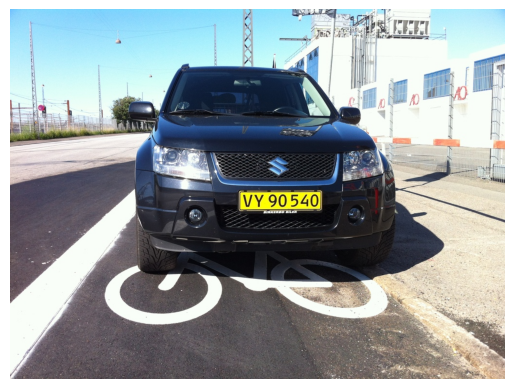

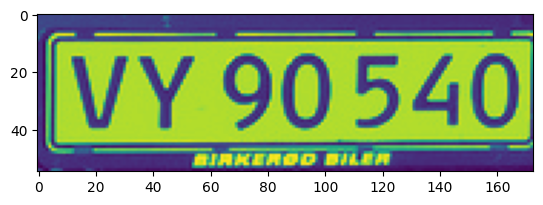

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Plate: Vy 9050
detected plate number is:  None


In [80]:
# plate_number=detect_plate_number("/kaggle/working/dataset/test/images/044417ca6134604f.jpg")
# print("detected plate number is: ",plate_number)
read_plate_number_from_predicted("/kaggle/working/dataset/test/images/288a95c01e43cd14.jpg")
# "/kaggle/working/dataset/test/images/fa897478280a2758.jpg"